In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 1. 데이터 로드 및 기본 확인
url = 'https://raw.githubusercontent.com/MyungKyuYi/AI-class/refs/heads/main/BP_data.csv'
data = pd.read_csv(url)
data

,Patient_Number,Blood_Pressure_Abnormality,Level_of_Hemoglobin,Genetic_Pedigree_Coefficient,Age,BMI,Sex,Pregnancy,Smoking,Physical_activity,salt_content_in_the_diet,alcohol_consumption_per_day,Level_of_Stress,Chronic_kidney_disease,Adrenal_and_thyroid_disorders
0,1,1,11.28,0.90,34,23,1,1.0,0,45961,48071,NaN,2,1,1
1,2,0,9.75,0.23,54,33,1,NaN,0,26106,25333,205.0,3,0,0
2,3,1,10.79,0.91,70,49,0,NaN,0,9995,29465,67.0,2,1,0
3,4,0,11.00,0.43,71,50,0,NaN,0,10635,7439,242.0,1,1,0
4,5,1,14.17,0.83,52,19,0,NaN,0,15619,49644,397.0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1996,1,10.14,0.02,69,26,1,NaN,1,26118,47568,144.0,3,1,0
1996,1997,1,11.77,1.00,24,45,1,1.0,1,2572,8063,NaN,3,1,1
1997,1998,1,16.91,0.22,18,42,0,NaN,0,14933,24753,NaN,2,1,1
1998,1999,0,11.15,0.72,46,45,1,NaN,1,18157,15275,253.0,3,0,1


In [3]:
# 데이터 크기와 컬럼 정보 확인
print("데이터 크기:", data.shape)
print("\n컬럼 정보:")
print(data.info())

데이터 크기: (2000, 15)

컬럼 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Patient_Number                 2000 non-null   int64  
 1   Blood_Pressure_Abnormality     2000 non-null   int64  
 2   Level_of_Hemoglobin            2000 non-null   float64
 3   Genetic_Pedigree_Coefficient   1908 non-null   float64
 4   Age                            2000 non-null   int64  
 5   BMI                            2000 non-null   int64  
 6   Sex                            2000 non-null   int64  
 7   Pregnancy                      442 non-null    float64
 8   Smoking                        2000 non-null   int64  
 9   Physical_activity              2000 non-null   int64  
 10  salt_content_in_the_diet       2000 non-null   int64  
 11  alcohol_consumption_per_day    1758 non-null   float64
 12  Level_of_Stress      

In [4]:
print("\n결측치 확인:")
print(data.isnull().sum())


결측치 확인:
Patient_Number                      0
Blood_Pressure_Abnormality          0
Level_of_Hemoglobin                 0
Genetic_Pedigree_Coefficient       92
Age                                 0
BMI                                 0
Sex                                 0
Pregnancy                        1558
Smoking                             0
Physical_activity                   0
salt_content_in_the_diet            0
alcohol_consumption_per_day       242
Level_of_Stress                     0
Chronic_kidney_disease              0
Adrenal_and_thyroid_disorders       0
dtype: int64


In [5]:
# 1-1. 결측치 처리: 각 컬럼의 중앙값(median)으로 대체
data = data.fillna(data.median())
print("After fillna, Data shape:", data.shape)
print(data.head())

After fillna, Data shape: (2000, 15)
   Patient_Number  Blood_Pressure_Abnormality  Level_of_Hemoglobin  \
0               1                           1                11.28   
1               2                           0                 9.75   
2               3                           1                10.79   
3               4                           0                11.00   
4               5                           1                14.17   

   Genetic_Pedigree_Coefficient  Age  BMI  Sex  Pregnancy  Smoking  \
0                          0.90   34   23    1        1.0        0   
1                          0.23   54   33    1        0.0        0   
2                          0.91   70   49    0        0.0        0   
3                          0.43   71   50    0        0.0        0   
4                          0.83   52   19    0        0.0        0   

   Physical_activity  salt_content_in_the_diet  alcohol_consumption_per_day  \
0              45961                     4

In [6]:
# 2. 정답 레이블 지정
# 두 번째 컬럼("Blood_Pressure_Abnormality")을 정답 레이블로 사용
label_col = data.columns[1]
print("Label column:", label_col)

Label column: Blood_Pressure_Abnormality


In [7]:
# 3. 입력 특성과 레이블 분리
# 레이블은 label_col, 특성은 그 외 모든 컬럼
X = data.drop(label_col, axis=1).values  
y = data[label_col].values  
print("Features shape:", X.shape)
print("Labels shape:", y.shape)

Features shape: (2000, 14)
Labels shape: (2000,)


In [8]:
# 4. 데이터 전처리 (입력 특성 스케일링)
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [9]:
# 5. 학습/테스트 셋 분할 (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train X shape:", X_train.shape, "Train y shape:", y_train.shape)
print("Test X shape:", X_test.shape, "Test y shape:", y_test.shape)

Train X shape: (1600, 14) Train y shape: (1600,)
Test X shape: (400, 14) Test y shape: (400,)


In [10]:
# 6. PyTorch 텐서 변환
# MLP는 2D 입력 (N, features)로 사용하므로 unsqueeze 하지 않는다.
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
# BCEWithLogitsLoss를 사용하므로 레이블은 float형, (N,1) 형태로 변환
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_tensor  = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [11]:
# 7. DataLoader 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [12]:
# 8. MLP 모델 정의 (BCE 방식, 출력 노드 1)
class BP_MLP_BCE(nn.Module):
    def __init__(self, input_dim):
        super(BP_MLP_BCE, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # 출력: 단일 로짓 값
        )
    
    def forward(self, x):
        return self.model(x)

input_dim = X_train_tensor.shape[1]
model = BP_MLP_BCE(input_dim)
print(model)

# 모델 요약 (입력 shape: (input_dim,))
summary(model, input_size=(input_dim,))

BP_MLP_BCE(
  (model): Sequential(
    (0): Linear(in_features=14, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]             960
              ReLU-2                   [-1, 64]               0
            Linear-3                   [-1, 32]           2,080
              ReLU-4                   [-1, 32]               0
            Linear-5                    [-1, 1]              33
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
---------------------------------------------------

In [13]:
# 9. 손실 함수 및 최적화기 설정 (BCEWithLogitsLoss 사용)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
# 10. 모델 학습 (BCE 기반)
num_epochs = 20
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        
        # labels는 이미 (batch, 1) float형임
        outputs = model(inputs)  # 출력 shape: (batch, 1)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)
    
    # 평가
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) >= 0.5).int()
            correct += (preds.squeeze(1) == labels.int()).sum().item()
            total += labels.size(0)
    
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")


Epoch 1/20, Loss: 0.6658, Accuracy: 1586.50%
Epoch 2/20, Loss: 0.5669, Accuracy: 1608.50%
Epoch 3/20, Loss: 0.5087, Accuracy: 1602.50%
Epoch 4/20, Loss: 0.4819, Accuracy: 1594.50%
Epoch 5/20, Loss: 0.4555, Accuracy: 1626.00%
Epoch 6/20, Loss: 0.4247, Accuracy: 1622.00%
Epoch 7/20, Loss: 0.3906, Accuracy: 1625.00%
Epoch 8/20, Loss: 0.3615, Accuracy: 1624.00%
Epoch 9/20, Loss: 0.3332, Accuracy: 1633.50%
Epoch 10/20, Loss: 0.3113, Accuracy: 1623.00%
Epoch 11/20, Loss: 0.2985, Accuracy: 1629.00%
Epoch 12/20, Loss: 0.2871, Accuracy: 1628.50%
Epoch 13/20, Loss: 0.2796, Accuracy: 1627.00%
Epoch 14/20, Loss: 0.2759, Accuracy: 1621.50%
Epoch 15/20, Loss: 0.2689, Accuracy: 1625.50%
Epoch 16/20, Loss: 0.2635, Accuracy: 1624.50%
Epoch 17/20, Loss: 0.2566, Accuracy: 1609.00%
Epoch 18/20, Loss: 0.2549, Accuracy: 1622.50%
Epoch 19/20, Loss: 0.2521, Accuracy: 1623.50%
Epoch 20/20, Loss: 0.2501, Accuracy: 1610.00%
Training complete.


Confusion Matrix:
[[191  32]
 [ 16 161]]


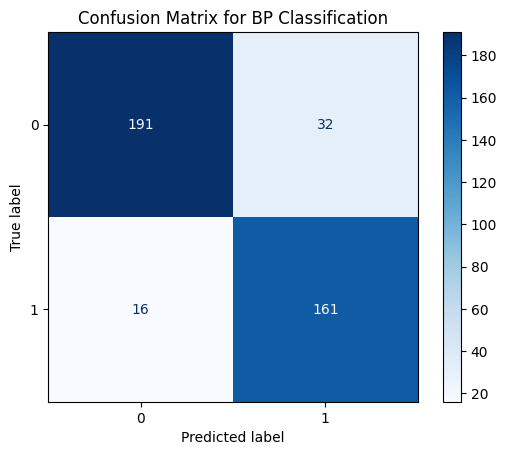

Test Accuracy: 0.88
F1 Score: 0.87
Precision: 0.83
Recall: 0.91


In [15]:
# 11. 모델 평가 및 혼동행렬 시각화
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        preds = (torch.sigmoid(outputs) >= 0.5).int()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(preds.cpu().numpy())

all_labels = np.array(all_labels).flatten()
all_predictions = np.array(all_predictions).flatten()

cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for BP Classification")
plt.show()

# 추가 평가 지표
acc = accuracy_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
print(f"Test Accuracy: {acc:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

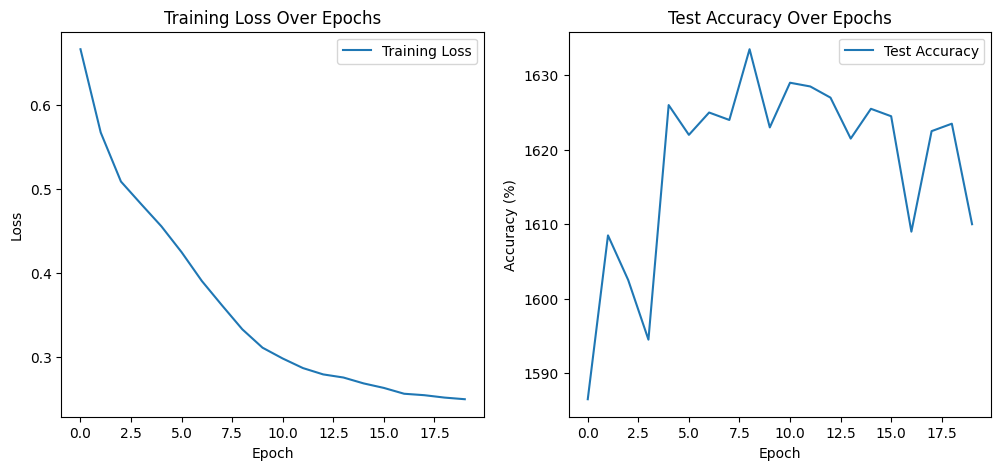

In [16]:
# 12. 학습 결과 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()